355 mb


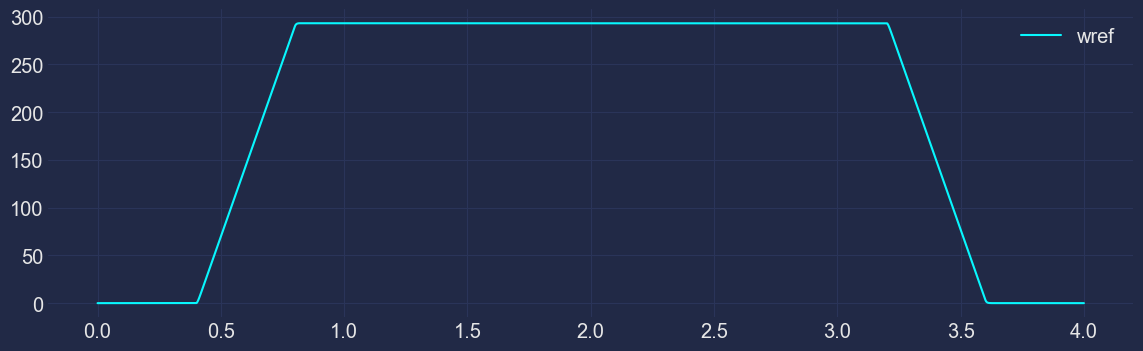

In [1]:
from cmath import pi
import pandas as pd
import matplotlib.pyplot as plt
import mplcyberpunk
import numpy as np
import math
import random
from sys import getsizeof

plt.style.use("cyberpunk")

sign = lambda x: math.copysign(1, x)

def cria_func(x,x2,A1,A2,intervalo):
    passo = ((x-x2))
    a = (A1-A2)/passo
    b = A2-a*x2
    vet = []
    
    for k in np.arange(x,x2+intervalo,intervalo):
        vet.append(a*(k)+b)
    return vet

def FEM_sqr(ang):
    pi = math.pi
    ang=ang%(2*pi)
    if ang < (90/180)*pi:
        return 1
    elif ang < (150/180)*pi:
        return ang*-6/pi+4
    elif ang < (270/180)*pi:
        return -1
    elif ang < (330/180)*pi:
        return ang*(6/(pi)) -10
    else:
        return 1

def DFEM_sqr(ang):
    pi = math.pi
    ang=ang%(2*pi)
    if ang < (90/180)*pi:
        return 0
    elif ang < (150/180)*pi:
        return -6/pi
    elif ang < (270/180)*pi:
        return 0
    elif ang < (330/180)*pi:
        return 6/pi
    else:
        return 0

def FEM_sin(ang):
    pi = math.pi
    ang=ang%(2*pi)
    pi = math.pi
    return math.sin(ang) + pi/3
    
def DFEM_sin(ang):
    pi = math.pi
    ang=ang%(2*pi)
    return math.cos(ang)

df = (2.0/3.0)*pi
FEM_SIN_A = lambda x: FEM_sin(x+df + pi/3.0)
FEM_SIN_C = lambda x: FEM_sin(x + pi/3.0)
FEM_SIN_B = lambda x: FEM_sin(x - df + pi/3.0)
# FEM_SIN_C = lambda x: FEM_sin(x)
# FEM_SIN_B = lambda x: FEM_sin(x + 2*pi/3.0)
# FEM_SIN_A = lambda x: FEM_sin(x - 2*pi/3.0)

#!Parametros do motor.
R           = 0.090
L           = 0.01*10**(-3)
J           = 0.01*10**(-3)
BV          = 0.62*10**(-3)
Ke          = 0.001
p           = 14
Pp          = p/2
M           = 0
Tmax        = 12
Rmax        = 11000
Rmax_rad    = Rmax*0.1047
rvolt       = Tmax/Rmax_rad
cmax        = 13
Tl          = 0.0667

# R           = 5.75
# L           = 0.55*pow(10,-3)
# J           = 0.87*pow(10,-3)
# BV          = 0.362*pow(10,-3)
# Ke          = 0.31
# p           = 4
# Pp          = p/2
# M           = 0
# Tmax        = 200
# Rmax        = 3500
# Rmax_rad    = 3500*0.1047
# rvolt       = Tmax/Rmax_rad
# cmax        = 40

#! Parametros da simulação
E           = Tmax
Nbits_pwm   = 6
P_pwm       = pow(2,Nbits_pwm)
Vmax        = Tmax

EAD         = 3
Nbits_ad    = 12
Q_ad        = pow(2,Nbits_ad)
offsetCS    = 0.5
K_ad        = EAD/Rmax
K_ad_current= EAD/cmax

clarke      = np.array([[math.sqrt(1/2), math.sqrt(1/2),   math.sqrt(1/2)],
                        [1,              -1/2,             -1/2],
                        [0,              math.sqrt(3)/2,   -math.sqrt(3)/2]])

clarke      = np.multiply(clarke,math.sqrt(2/3))
inversor    = np.array([[2/3,       -1/3,        -1/3],
                        [-1/3,      2/3,         -1/3],
                        [-1/3,      -1/3,        2/3]])

inv_clarke  = np.linalg.inv(clarke)

def Park(theta):
    return np.array([[1, 0,                     0],
                    [0, math.cos(theta),  math.sin(theta)],
                    [0, -math.sin(theta), math.cos(theta)]],dtype=np.float64)

def InvPark(theta):
    return np.array([[1,           0,                            0],
                    [0,            math.cos(theta),              -math.sin(theta)],
                    [0,            math.sin(theta),              math.cos(theta)]],dtype=np.float64)
    
inv_park = lambda theta: InvPark(theta)
park     = lambda theta: Park(theta)

#! Motor
Ai          = np.array([[-R/(L-M),    0,           0,           -Pp*Ke/(L-M),         0],
                        [0,           -R/(L-M),    0,           -Pp*Ke/(L-M),         0],
                        [0,           0,           -R/(L-M),    -Pp*Ke/(L-M),         0],
                        [Pp*Ke/J,     Pp*Ke/J,     Pp*Ke/J,     -BV/J,                0],
                        [0,           0,           0,           Pp,                   0]])


B           = np.array([[1/(L-M),      0,           0,           0],
                        [0,            1/(L-M),     0,           0],
                        [0,            0,           1/(L-M),     0],
                        [0,            0,           0,           -1/J],
                        [0,            0,           0,           0]])

C           = np.array([[1, 0, 0, 0, 0],
                        [0, 1, 0, 0, 0],
                        [0, 0, 1, 0, 0]],dtype=np.float64)

I5          = np.array([[1, 0, 0, 0, 0],
                        [0, 1, 0, 0, 0],
                        [0, 0, 1, 0, 0],
                        [0, 0, 0, 1, 0],
                        [0, 0, 0, 0, 1]])


I3          = np.array([[1, 0, 0],
                        [0, 1, 0],
                        [0, 0, 1]])

I3_1        = np.array([1,1,1])

#! Parametros simulação
fadc        = 10*10**(3)
Tadc        = 1/fadc
Tc          = Tadc/P_pwm
Tsim        = 4
pi          = math.pi

adc_to_rpm  = Rmax/(2**Nbits_ad)
rpm_to_rad  = 2*pi/60
Tload       = 0

x           = np.arange(0,Tsim,Tadc)
x_tc        = np.arange(0,Tsim,Tc)
N           = len(x)
ym          = np.zeros(N)

Vabc_n      = np.zeros((3,N*P_pwm+P_pwm))
Vabc_g      = np.zeros((3,N))
back        = np.zeros((3,N*P_pwm+P_pwm))
V           = np.zeros(N)
angulo      = np.zeros(N)

t           = np.zeros(N)
tc          = np.zeros(N*P_pwm+P_pwm)

Vpwm        = np.zeros((3,N*P_pwm+P_pwm))

X           = np.zeros((5,N*P_pwm+P_pwm))
yn          = np.zeros((3,N*P_pwm+P_pwm))

Valpha_beta = np.zeros((3,N))
Vqd         = np.zeros((3,N))
i0qd        = np.zeros((3,N))
erro        = np.zeros(N)
erro2       = np.zeros(N)
erro3       = np.zeros(N)
kc          = 0

ang         = 73*pi/180
theta       = ang
thetae      = ang
theta_pwm   = ang
thetae_pwm  = ang
angulo[0]   = ang
w           = 0
wr          = 0
wn          = Rmax_rad
Gf          = Tmax/wn
wn2         = wn*0.8

alim        = (0.1*Tsim)
V_alin      = 0

#! Controladores
p1          = 50
i1          = 0*Tadc
d1          = 0
PID_1       = 0
P_1         = 0
I_1         = 0
D_1         = 0

p2          = 1
i2          = 0.01*Tadc
d2          = 0
PID_2       = 0
P_2         = 0
I_2         = 0
D_2         = 0

p3          = p2
i3          = i2
d3          = d2
PID_3       = 0
P_3         = 0
I_3         = 0
D_3         = 0

wref = cria_func(0,0.1*Tsim,0,0,Tadc) + cria_func(0.1*Tsim+Tadc,0.2*Tsim,0,wn2,Tadc) + cria_func(0.2*Tsim+Tadc,0.8*Tsim,wn2,wn2,Tadc) + cria_func(0.8*Tsim+Tadc,0.9*Tsim,wn2,0,Tadc) + cria_func(0.9*Tsim+Tadc,Tsim-2*Tadc,0,0,Tadc)
for k in range(1,len(wref)):
    wref[k] = 0.98*wref[k-1] + 0.02*wref[k]

f=plt.figure(1)
f.set_size_inches(14, 4)
plt.step(x,wref,label="wref")
plt.grid(True)
plt.legend()
plt.legend(fontsize="x-large")
plt.xticks(fontsize="x-large")
plt.yticks(fontsize="x-large")
# mplcyberpunk.add_glow_effects()
plt.savefig('Resultados/referencia.pdf')

print(round((getsizeof(x)+getsizeof(X)+getsizeof(yn)+getsizeof(Vqd)+getsizeof(Vabc_g)+getsizeof(Vabc_n)+getsizeof(t)+getsizeof(tc)+getsizeof(Vpwm)+getsizeof(back)+getsizeof(ym)+getsizeof(V)+getsizeof(wref))/1024/1024), "mb")

In [2]:
for k in range(1,N-1):
    t[k] = Tadc*k
    
    #! Calculo do da posição angular do rotor
    angulo[k] = (angulo[k-1] + ym[k]*Tadc)%(2*pi)
    theta = angulo[k]
    thetae = (thetae + ym[k]*Pp*Tadc)%(2*pi*Pp)
    
    #! Calculo das correntes em AlphaBeta
    [ia, ib, ic] = yn[:,kc]
    
    Vabc_g[:,k] = clarke@[ia,ib,ic]
    i0qd[:,k]   = park(thetae)@Vabc_g[:,k]
    
    if t[k] <= alim:
        if V_alin > Tmax:
            V_alin = Tmax
        Vqd[:,k] = [V_alin,V_alin,0]
        V_alin=V_alin+0.05
        Vn = [abs(Vqd[0,k])*P_pwm/E, abs(Vqd[1,k])*P_pwm/E, abs(Vqd[2,k])*P_pwm/E]
    else:
        
        #! Calculo do erro de velocidade
        erro[k] = wref[k] - ym[k]
        
        #! Controlador para a velocidade
        P_1 = erro[k]*p1
        I_1 = erro[k]*i1+I_1
        D_1 = 0.9*D_1 + 0.1*(d1*(erro[k]-erro[k-1]))
        PID_1 = P_1+D_1+I_1
        if PID_1 > Tmax:
            PID_1=Tmax
        if PID_1 < -Tmax:
            PID_1 = -Tmax
        
        iq = i0qd[2,k]
        id = i0qd[1,k]
        
        erro2[k] = PID_1 - iq
        P_2 = erro2[k]*p2
        I_2 = erro2[k]*i2+I_2
        D_2 = 0.9*D_2 + 0.1*(d2*(erro2[k]-erro2[k-1]))
        PID_2 = P_2+I_2+D_2
        if PID_2 > Tmax:
            PID_2 = Tmax
        if PID_2 < -Tmax:
            PID_2 = -Tmax
        
        erro3[k] = 0 - id
        P_3 = erro3[k]*p3
        I_3 = erro3[k]*i3+I_3
        D_3 = 0.9*D_3 + 0.1*(d3*(erro3[k]-erro3[k-1]))
        PID_3 = P_3+I_3+D_3
        if PID_3 > Tmax:
            PID_3 = Tmax
        if PID_3 < -Tmax:
            PID_3 = -Tmax
        
        q = PID_2
        d = PID_3
        
        Vqd[:,k] = inv_clarke@(inv_park(thetae)@[i0qd[0,k], d, q])
        Vn = [abs(Vqd[0,k])*P_pwm/E, abs(Vqd[1,k])*P_pwm/E, abs(Vqd[2,k])*P_pwm/E]
    
    for cc in range(0,P_pwm):
        kc = k*P_pwm+cc
        tc[kc] = kc*Tc
        
        for aux in range(0,3):
            if cc < Vn[aux]:
                Vpwm[aux,kc] = sign(Vqd[aux,k])*E
            else:
                Vpwm[aux,kc] = 0
        
        #! Calculo do torque
        Tl = X[3,kc]*0.05*Tload/Rmax
        
        #! Calculo da BACK-EMF
        back[:,kc]  = (np.multiply([FEM_SIN_A(thetae_pwm),FEM_SIN_B(thetae_pwm),FEM_SIN_C(thetae_pwm)],Ke*X[3,kc]))
        
        #! Calculo da Tensao com referencia a junção das fases.
        Vabc_n[:,kc] = (inversor@Vpwm[:,kc])+np.multiply(back[:,kc],1/3)
        Vn_pwm = [Vabc_n[0,kc],Vabc_n[1,kc],Vabc_n[2,kc],Tl]
        
        #! Calculo das matrizes do sistema e discretização delas
        Ax     = np.array([[ 1,                             1,                            1,                          FEM_SIN_A(thetae_pwm),            1],
                            [1,                             1,                            1,                          FEM_SIN_B(thetae_pwm),            1],
                            [1,                             1,                            1,                          FEM_SIN_C(thetae_pwm),            1],
                            [FEM_SIN_A(thetae_pwm),         FEM_SIN_B(thetae_pwm),        FEM_SIN_C(thetae_pwm),      1,                                1],
                            [1,                             1,                            1,                          1,                                1]],dtype=np.float64)
        Ac = Ai*Ax
        Ad = I5+Ac*Tc+(Ac**2)/2*Tc**2
        Bd = ((I5*Tc)+(Ac/2)*(Tc**2))@B
        # Ad = I5+Ac*Tc
        # Bd = B*Tc
        
        #! Calculo do modelo
        X[:,kc+1] = Ad@X[:,kc]+Bd@Vn_pwm
        yn[:,kc+1] = C@X[:,kc+1] #+ I3_1*random.random()
        
        #! Calculo do da posição angular do rotor
        theta_pwm  = (theta_pwm + X[3,kc+1]*Tc)%(2*pi)
        thetae_pwm = (thetae_pwm + X[3,kc+1]*Pp*Tc)%(Pp*2*pi)
    
    ym[k+1] = X[3,kc+1]
t[k] = Tadc*k
t[N-1] = Tadc*N

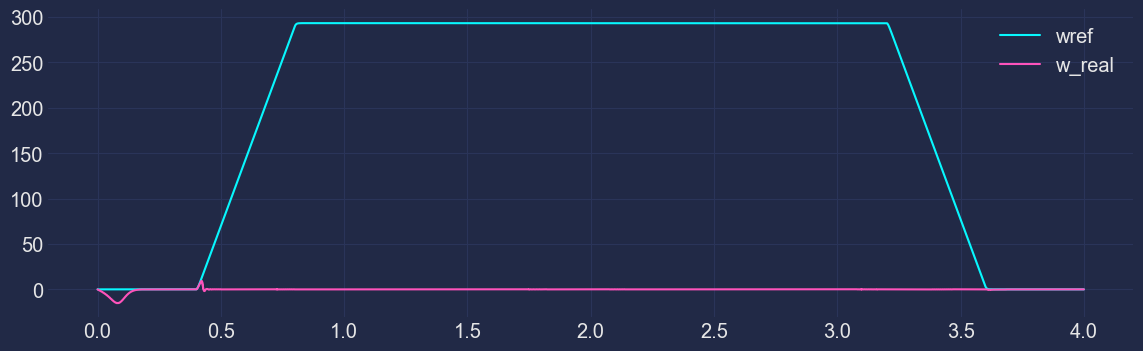

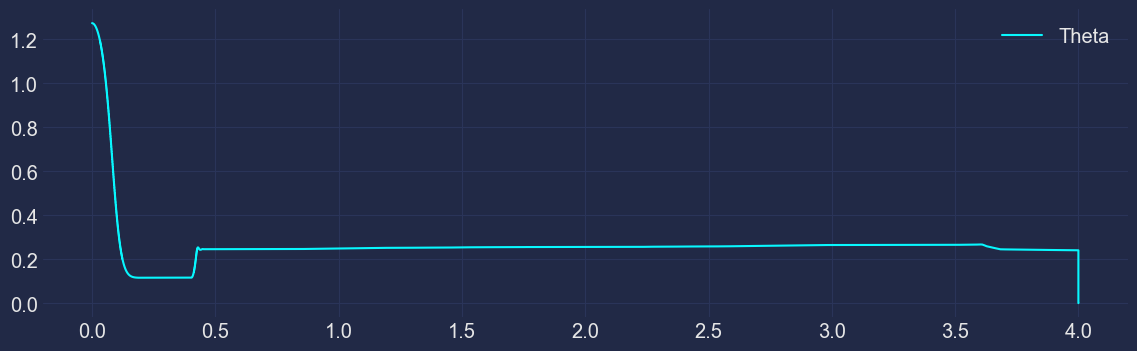

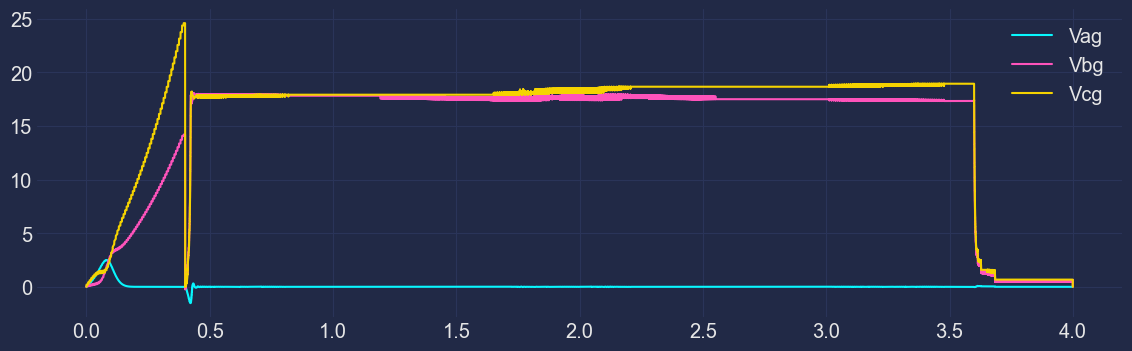

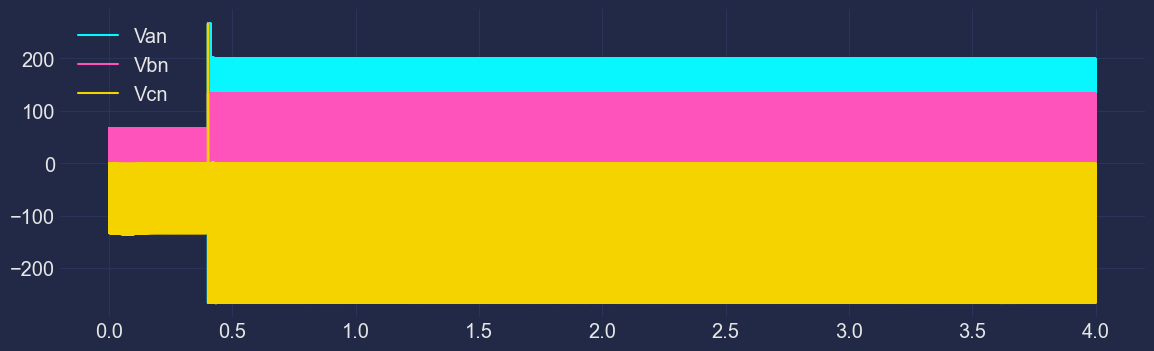

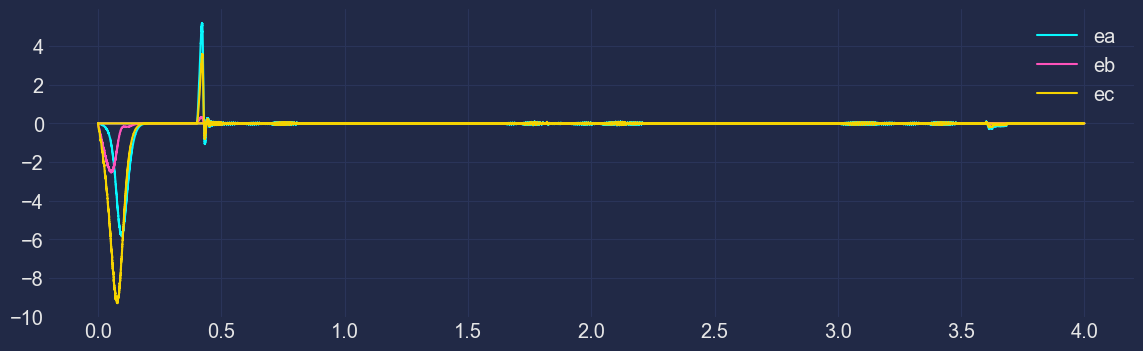

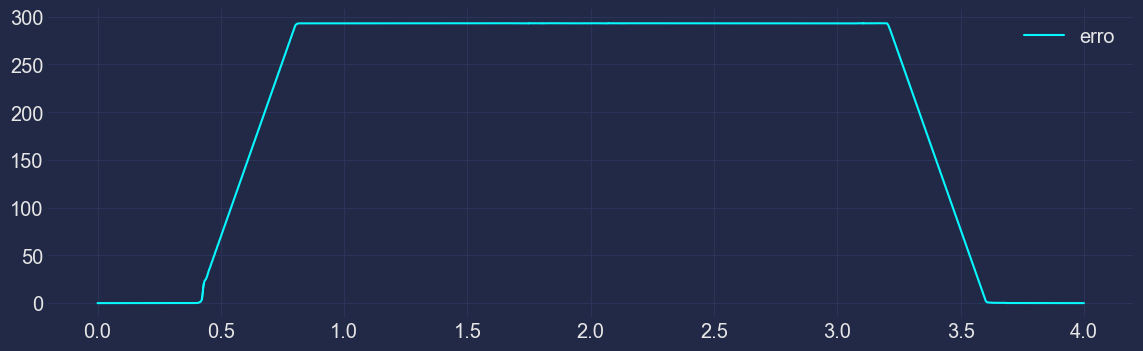

In [3]:
fig = 2
f=plt.figure(fig)
f.set_size_inches(14, 4)
plt.step(x,wref,label="wref")
plt.step(x,ym,label="w_real")
#plt.ylim(-10,80)
plt.grid(True)
plt.legend()
plt.legend(fontsize="x-large")
plt.xticks(fontsize="x-large")
plt.yticks(fontsize="x-large")
# mplcyberpunk.add_glow_effects()
plt.savefig('Resultados/saida.pdf')
fig = fig+1

f=plt.figure(fig)
f.set_size_inches(14, 4)
plt.step(x,angulo,label="Theta")
plt.grid(True)
plt.legend()
plt.legend(fontsize="x-large")
plt.xticks(fontsize="x-large")
plt.yticks(fontsize="x-large")
# mplcyberpunk.add_glow_effects()
plt.savefig('Resultados/angulo.pdf')
fig=fig+1

f=plt.figure(fig)
f.set_size_inches(14, 4)
plt.step(x,Vabc_g[0,:],label="Vag")
plt.step(x,Vabc_g[1,:],label="Vbg")
plt.step(x,Vabc_g[2,:],label="Vcg")
plt.grid(True)
plt.legend()
plt.legend(fontsize="x-large")
plt.xticks(fontsize="x-large")
plt.yticks(fontsize="x-large")
# mplcyberpunk.add_glow_effects()
plt.savefig('Resultados/tensoes_inversor.pdf')
fig=fig+1

f=plt.figure(fig)
f.set_size_inches(14, 4)
plt.step(tc,Vabc_n[0,:],label="Van")
plt.step(tc,Vabc_n[1,:],label="Vbn")
plt.step(tc,Vabc_n[2,:],label="Vcn")
plt.grid(True)
plt.legend()
plt.legend(fontsize="x-large")
plt.xticks(fontsize="x-large")
plt.yticks(fontsize="x-large")
# mplcyberpunk.add_glow_effects()
plt.savefig('Resultados/tensoes_inversor.pdf')
fig = fig+1

f=plt.figure(fig)
f.set_size_inches(14, 4)
plt.step(tc,back[0,:],label="ea")
plt.step(tc,back[1,:],label="eb")
plt.step(tc,back[2,:],label="ec")
plt.grid(True)
plt.legend()
plt.legend(fontsize="x-large")
plt.xticks(fontsize="x-large")
plt.yticks(fontsize="x-large")
# mplcyberpunk.add_glow_effects()
plt.savefig('Resultados/V.pdf')
fig=fig+1

f=plt.figure(fig)
f.set_size_inches(14, 4)
plt.step(x,erro,label="erro")
plt.grid(True)
plt.legend()
plt.legend(fontsize="x-large")
plt.xticks(fontsize="x-large")
plt.yticks(fontsize="x-large")
# mplcyberpunk.add_glow_effects()
plt.savefig('Resultados/V.pdf')
fig=fig+1

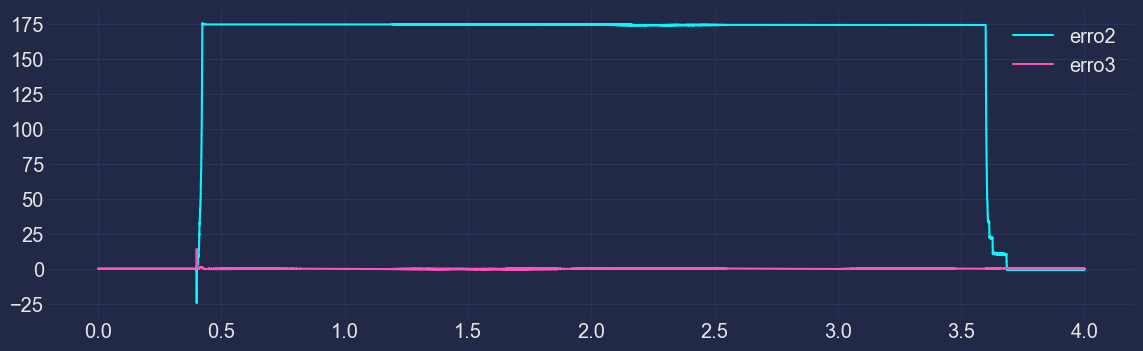

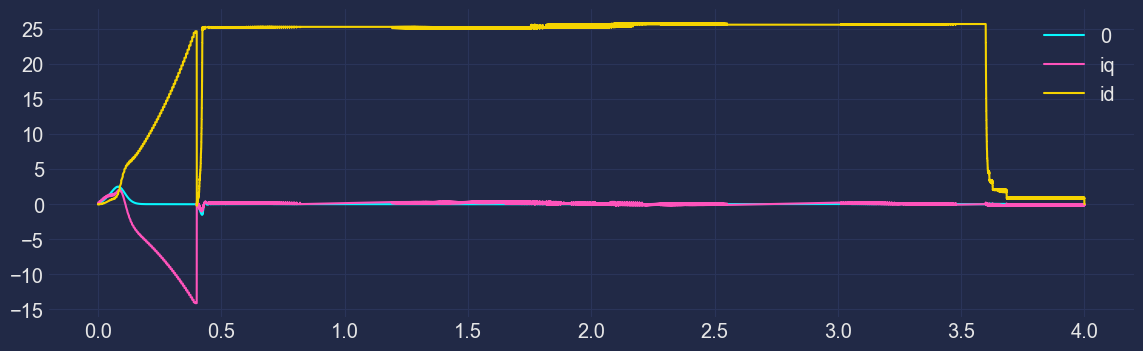

In [4]:
f=plt.figure(fig)
f.set_size_inches(14, 4)
plt.step(x,erro2,label="erro2")
plt.step(x,erro3,label="erro3")
plt.grid(True)
plt.legend()
plt.legend(fontsize="x-large")
plt.xticks(fontsize="x-large")
plt.yticks(fontsize="x-large")
fig = fig+1

f=plt.figure(fig)
f.set_size_inches(14, 4)
plt.step(x,i0qd[0,:],label="0")
plt.step(x,i0qd[1,:],label="iq")
plt.step(x,i0qd[2,:],label="id")
plt.grid(True)
plt.legend()
plt.legend(fontsize="x-large")
plt.xticks(fontsize="x-large")
plt.yticks(fontsize="x-large")
fig = fig+1

In [5]:
Rmax

3500